In [1]:
import sqlite3
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
%matplotlib notebook


DB = 'AreaOvitrap.db'

def run_query(query,date_col = None):
    with sqlite3.connect(DB) as conn:
        if date_col is not None:
            date = {date_col:"%m-%Y"}
            return pd.read_sql(query,conn,parse_dates = date)
        else:
            return pd.read_sql(query,conn)

def run_command(command):
    with sqlite3.connect(DB) as conn:
        conn.execute('PRAGMA foreign_keys = ON;')
        conn.isolation_level = None
        conn.execute(command)

def show_tables():        
    query = '''
        SELECT name,
               type
        From sqlite_master
        WHERE type IN ("type","view");
    '''
    return run_query(query)

def get_yr_mean(year):
    dis_yr = district_yoi[district_yoi.year == str(year)].loc[:,"ovitrap_index"]
    dis_yr = dis_yr.reset_index(drop=True)
    return dis_yr

def top_three(year):
    year_mean = get_yr_mean(year)
    sorted_mean = sorted(year_mean,reverse=True)
    top_three = sorted_mean[0:3]
    top_three_index = []
    for each in top_three:
        for index, value in enumerate(year_mean):
            if each == value:
                top_three_index.append(index)
    return top_three_index

def set_districts(pos):
    district_labels = [" " for _ in range(19)]
    districts = list(district_yoi['district'].unique())
    for index, each in enumerate(pos):
        district_labels[each] = districts[each]
    return district_labels

def set_colors(pos):
    bar_colors = ['#D1D0CE' for _ in range(19)]
    top_three_colors = ['black','red','orange']
    for index, each in enumerate(pos):
        bar_colors[each] = top_three_colors[index]
    return bar_colors


In [2]:
district_yoi_list = []
placeholder = ['%'+str(i) for i in range(2008,2018)]
conn = sqlite3.connect(DB)
c = conn.cursor()
for each in placeholder:
    query = '''
        WITH 
            location_avg AS (
                SELECT
                    la.eng_location,
                    date,
                    AVG(la.AOI)*100 location_avg
                FROM (
                    SELECT 
                        l.eng_location,
                        aoi.date,
                        aoi.AOI
                    FROM area_ovitrap_index aoi
                    INNER JOIN location l ON l.location_id = aoi.location_id
                    WHERE aoi.date LIKE ?) la
                GROUP BY la.eng_location),
                    
            district_avg AS (
                SELECT
                    ad.eng_district,
                    ad.date,
                    AVG(ad.location_avg) district_avg
                FROM (
                    SELECT 
                        d.eng_district,
                        la.eng_location,
                        la.date,
                        la.location_avg
                    FROM location_avg la
                    INNER JOIN location l ON l.eng_location = la.eng_location
                    INNER JOIN district d ON l.district_id = d.district_id) ad
                GROUP BY ad.eng_district
                    )
            
        SELECT 
            eng_district district, 
            substr(date,pos+1) year, 
            district_avg ovitrap_index
        FROM
            (SELECT *, instr(date,'-') as pos
            FROM district_avg)
            '''
    c.execute(query,(each,))
    for each in c.fetchall():
        district_yoi_list.append(list(each))
district_yoi = pd.DataFrame(district_yoi_list,columns=['district','year','ovitrap_index'])


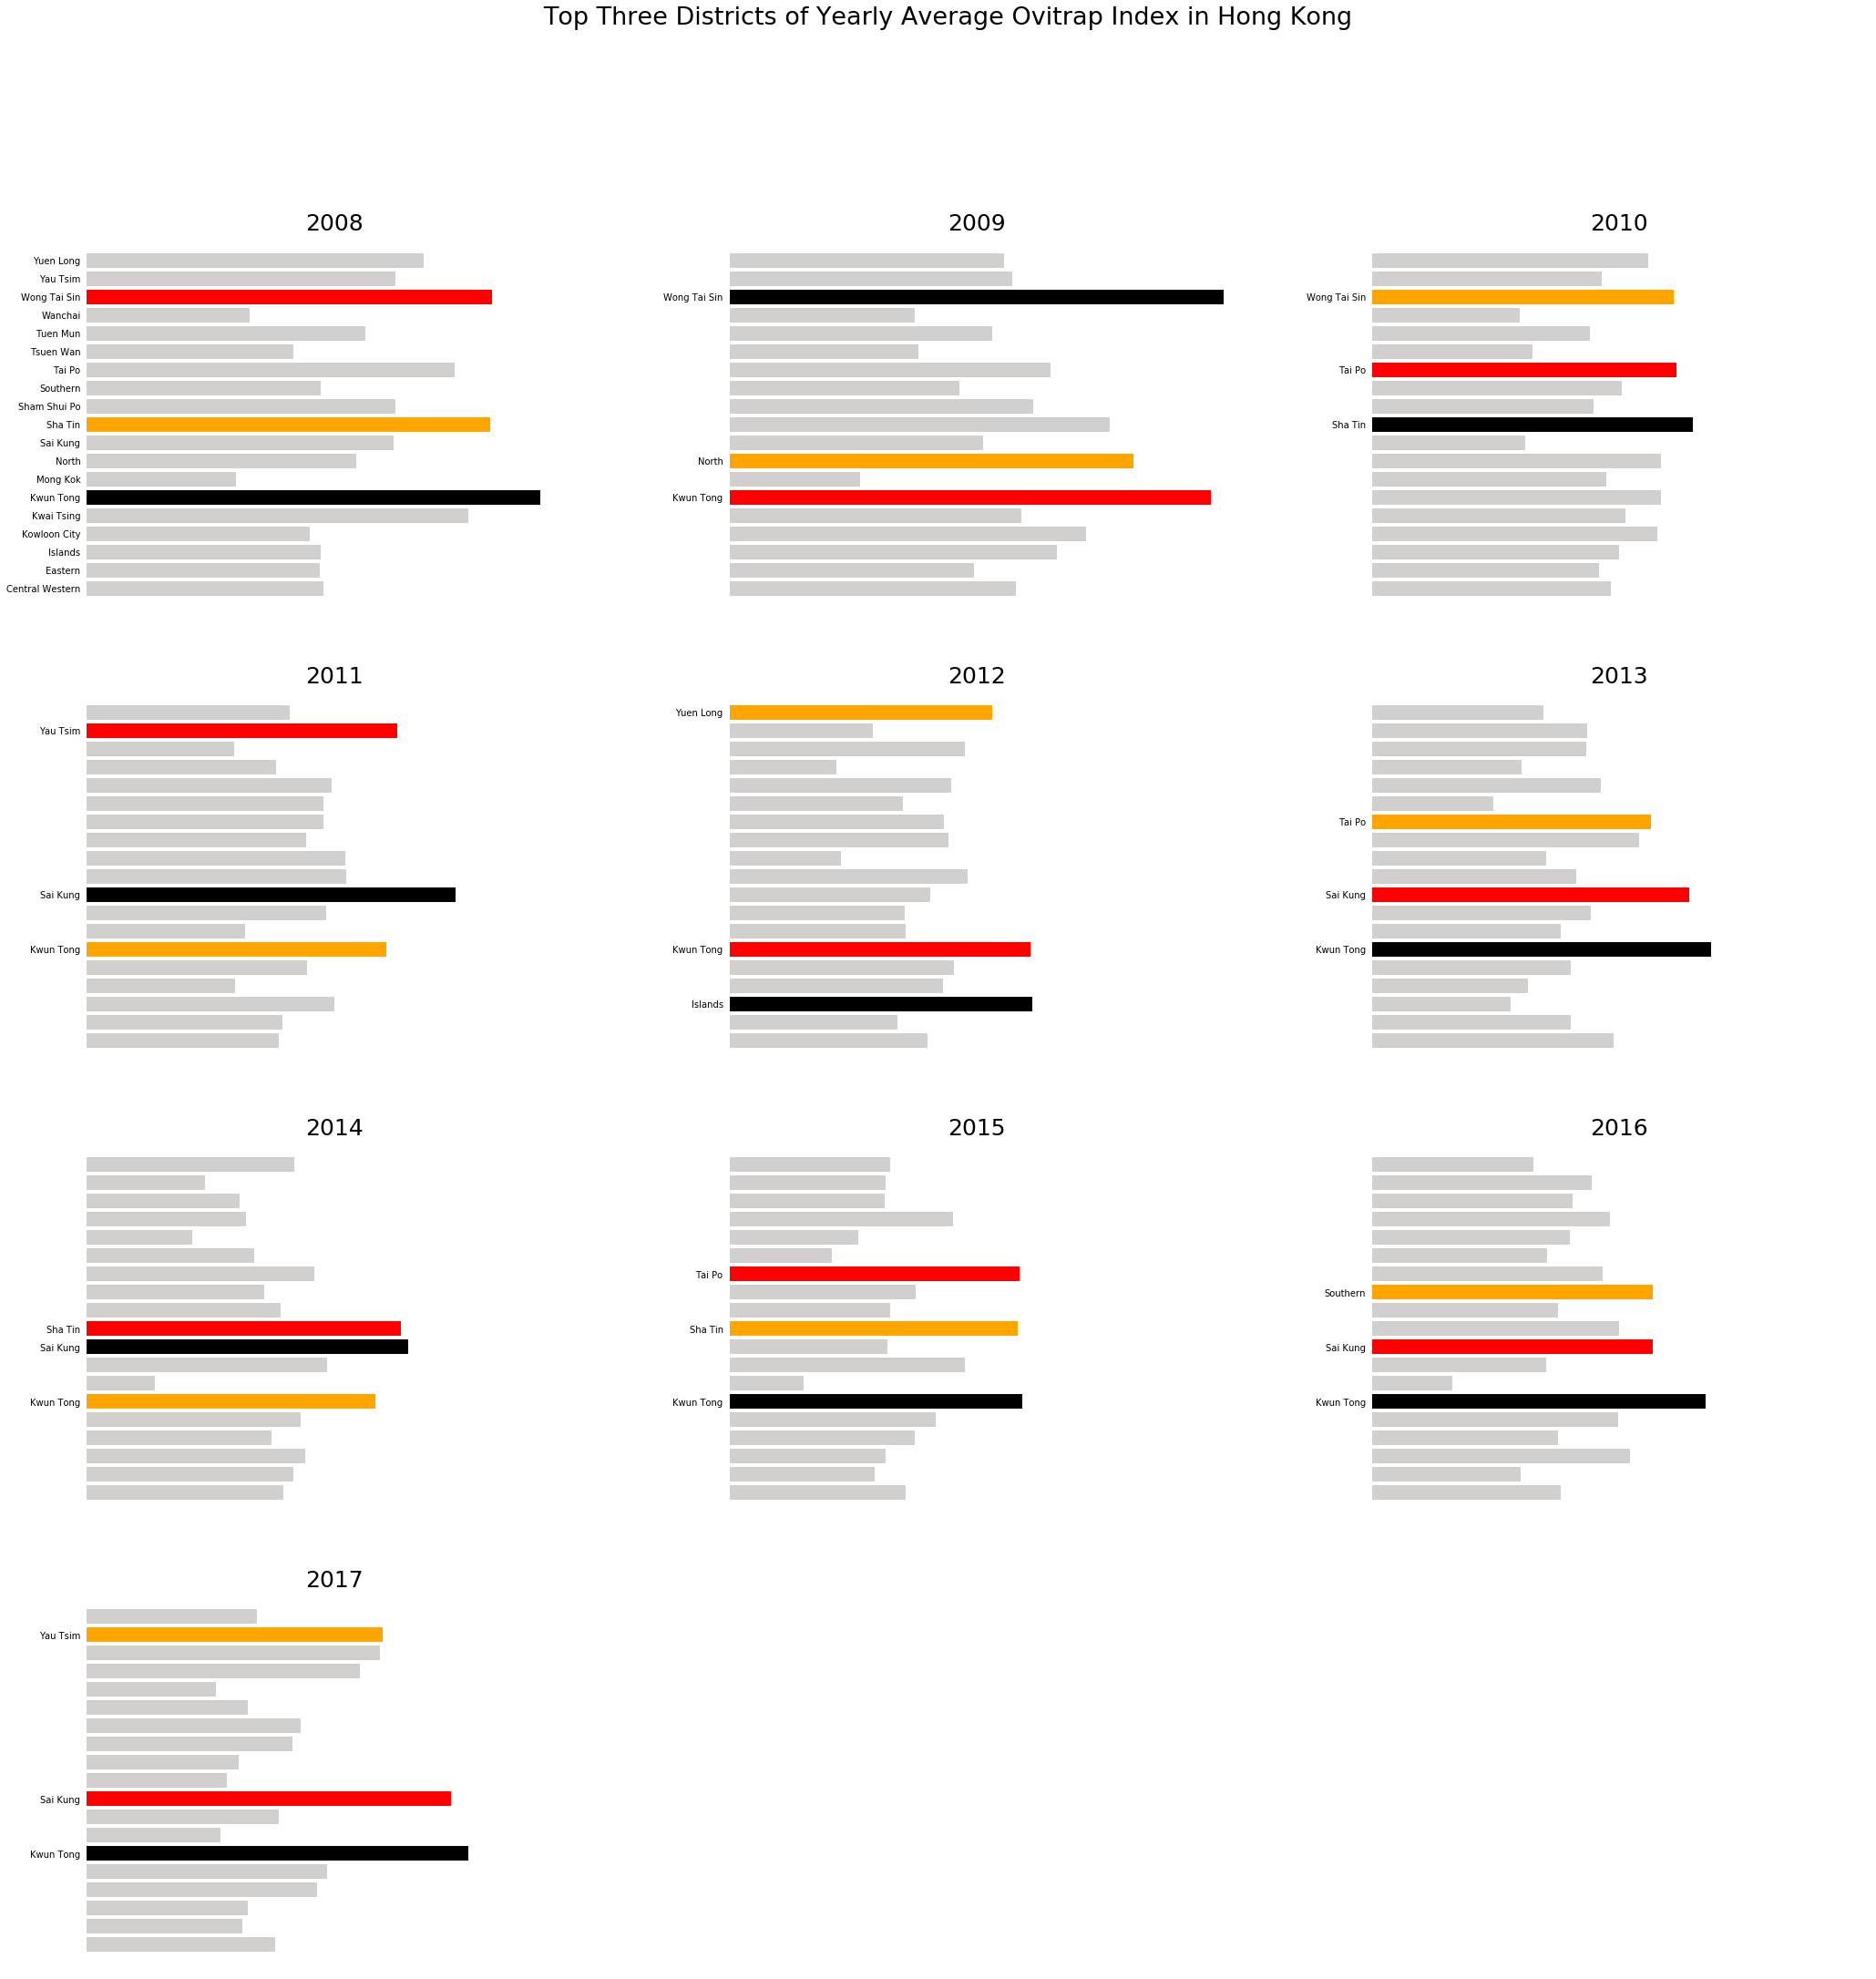

In [3]:
years = [i for i in range(2008,2018)]
y_pos = [0.5+i for i in range(1,20)]

fig = plt.figure(figsize=(35,35))
fig.suptitle("Top Three Districts of Yearly Average Ovitrap Index in Hong Kong",size='27')
for index, year in enumerate(years):
    ax = fig.add_subplot(4,3,index+1)
    top_three_index = top_three(year)
    labels = set_districts(top_three_index)
    bar_colors = set_colors(top_three_index)
    if year == 2008:
        ax.barh(y_pos,get_yr_mean(year),color=bar_colors,tick_label=list(district_yoi['district'].unique()))
    else:
        ax.barh(y_pos,get_yr_mean(year),color=bar_colors,tick_label=labels)
    ax.set_title(year,size='25')
    plt.xticks([])
    plt.xlim(0,10)
    plt.subplots_adjust(wspace=0.3)
    ax.tick_params(bottom=False,left=False)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
plt.savefig("year_top_three_district")
plt.show()    

Traceback (most recent call last):
  File "/Users/danielho/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 387, in process
    proxy(*args, **kwargs)
  File "/Users/danielho/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 227, in __call__
    return mtd(*args, **kwargs)
  File "/Users/danielho/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1026, in _start
    self._init_draw()
  File "/Users/danielho/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1750, in _init_draw
    self._draw_frame(next(self.new_frame_seq()))
  File "/Users/danielho/anaconda3/lib/python3.6/site-packages/matplotlib/animation.py", line 1775, in _draw_frame
    raise RuntimeError('The animation function must return a '
RuntimeError: The animation function must return a sequence of Artist objects.


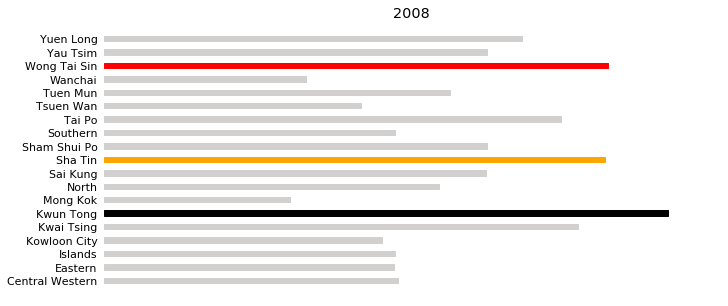

In [4]:
y_pos = [0.5+i for i in range(1,38,2)]
labels = list(district_yoi['district'].unique())
fig = plt.figure(figsize=(11,5))
ax = plt.axes(xlim=(0,10))
test=plt.barh(y_pos, [0 for _ in range(19)])
plt.yticks(y_pos,labels,size=11)
plt.xticks([])
plt.tick_params(bottom=False,left=False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)

def animate(i):
    y_data = get_yr_mean(2008+i)
    ax.set_title(2008+i,size='x-large')
    bar_colors = set_colors(top_three(2008+i))
    for i, b in enumerate(test):
        b.set_width(y_data[i])
        b.set_color(bar_colors[i])

anim = animation.FuncAnimation(fig,animate,blit=True,frames=10,interval=3000)

plt.show()


In [5]:
from collections import Counter
year_top_three = []
for year in years:
    top_three_index = top_three(year)
    top_three_districts = set_districts(top_three_index)
    year_top_three.append(top_three_districts)
count=[]
for each in year_top_three:
    for value in each:
        if value is not " ":
            count.append(value)
total_count = Counter(count)
total_count = sorted(total_count.items(),key=lambda x: x[1],reverse=True)
total_count

[('Kwun Tong', 9),
 ('Sai Kung', 5),
 ('Sha Tin', 4),
 ('Wong Tai Sin', 3),
 ('Tai Po', 3),
 ('Yau Tsim', 2),
 ('North', 1),
 ('Islands', 1),
 ('Yuen Long', 1),
 ('Southern', 1)]

In [6]:
ktd_yoi_list = []
placeholder = ['%'+str(i) for i in range(2008,2018)]
conn = sqlite3.connect(DB)
c = conn.cursor()
for each in placeholder:
    query = '''
    WITH 
        location_avg AS (
            SELECT
                la.eng_location,
                date,
                AVG(la.AOI)*100 location_avg
            FROM (
                SELECT 
                    l.eng_location,
                    aoi.date,
                    aoi.AOI
                FROM area_ovitrap_index aoi
                INNER JOIN location l ON l.location_id = aoi.location_id
                WHERE aoi.date LIKE ?) la
            GROUP BY la.eng_location),
        kwun_tong_district AS(
            SELECT 
                la.eng_location,
                date,
                location_avg
            FROM location_avg la
            INNER JOIN location l ON la.eng_location = l.eng_location
            INNER JOIN district d ON l.district_id = d.district_id
            WHERE d.eng_district = 'Kwun Tong'
        )
    SELECT 
        eng_location location, 
        substr(date,pos+1) year, 
        location_avg ovitrap_index
    FROM
        (SELECT *, instr(date,'-') as pos
        FROM kwun_tong_district)

'''
    c.execute(query,(each,))
    for each in c.fetchall():
        ktd_yoi_list.append(list(each))
ktd_yoi = pd.DataFrame(ktd_yoi_list,columns=['location','year','ovitrap_index'])


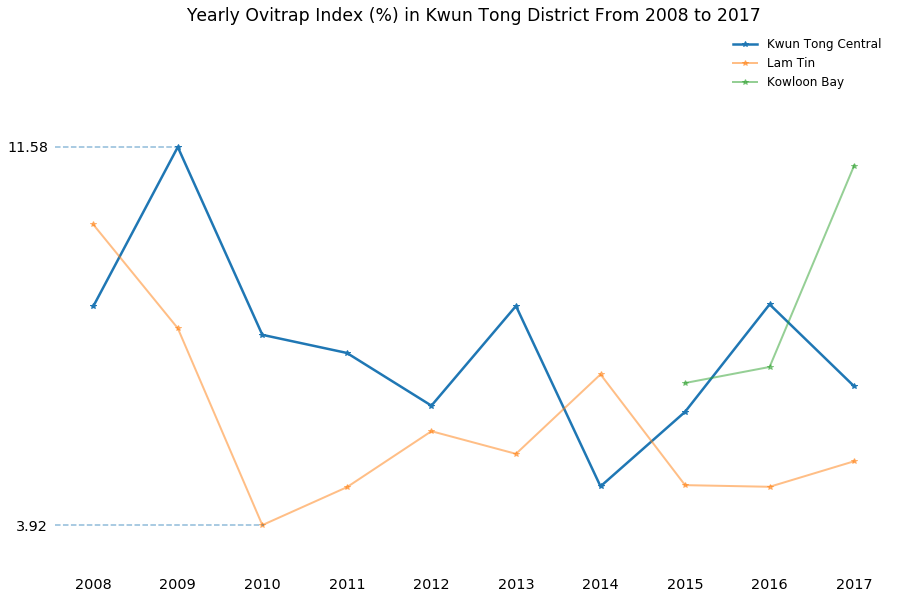

In [7]:
kwun_tong_central = ktd_yoi[ktd_yoi.location=='Kwun Tong Central']['ovitrap_index']
lam_tin = ktd_yoi[ktd_yoi.location=='Lam Tin']['ovitrap_index']
kowloon_bay = ktd_yoi[ktd_yoi.location=='Kowloon Bay']['ovitrap_index']
highest = max(kwun_tong_central)
lowest = min(lam_tin)

fig,ax = plt.subplots(figsize=(15,10))
ax.plot(years,kwun_tong_central,marker='*',linewidth=2.5,label='Kwun Tong Central')
ax.plot(years,lam_tin,marker='*',alpha=0.5,linewidth=2,label='Lam Tin')
ax.plot([2015,2016,2017],kowloon_bay,marker='*',alpha=0.5,linewidth=2,label='Kowloon Bay')

plt.xticks(years,size='x-large')
ax.tick_params(bottom=False,left=False)
plt.ylim(3,14)
plt.yticks(np.round([highest,lowest],2),size='x-large')
plt.axhline(highest,xmax=1.5/10,alpha=0.5,linestyle='--')
plt.axhline(lowest,xmax=2.5/10,alpha=0.5,linestyle='--')
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.title("Yearly Ovitrap Index (%) in Kwun Tong District From 2008 to 2017",size='xx-large')
plt.legend(frameon=False,fontsize='large')
plt.savefig('KTD_YOI')
plt.show()

In [10]:
all_district_2018_q = '''
 SELECT
    eng_district,
    date,
    AVG(AOI) monthly_aoi
    FROM
        (SELECT
            eng_district,
            aoi.date,
            aoi.AOI*100 AOI
        FROM area_ovitrap_index aoi
        INNER JOIN location l ON aoi.location_id = l.location_id
        INNER JOIN district d ON l.district_id = d.district_id
        WHERE d.eng_district = ? AND aoi.date LIKE '%2018' AND aoi.date != '08-2018'
        ) 
    GROUP BY date
'''
all_district_2018_list = []
districts = run_query('''SELECT d.eng_district FROM district d''')
conn = sqlite3.connect(DB)
c = conn.cursor()
for district in districts['eng_district']:
    c.execute(all_district_2018_q,(district,))
    for each in c.fetchall():
        all_district_2018_list.append(list(each))
        
all_district_2018 = pd.DataFrame(all_district_2018_list,columns=['district','date','aoi'])


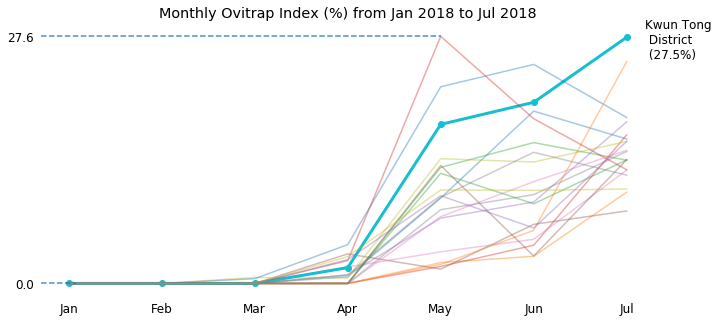

In [31]:
months_2018 = [i for i in range(1,8)]
months_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul']
highest = max(all_district_2018['aoi'])
fig, ax = plt.subplots(figsize=(11,5))
for district in districts['eng_district']:
    if district == 'Kwun Tong':
        ax.plot(months_2018,all_district_2018[all_district_2018.district == district]['aoi'],linewidth=3,marker='o',label=district)
    else:
        ax.plot(months_2018,all_district_2018[all_district_2018.district == district]['aoi'],alpha=0.4,label=district)
ax.text(7.2,highest-2.5,'Kwun Tong\n District\n (27.5%)',size='large')
plt.xticks(months_2018,months_label,size='large')
plt.tick_params(bottom=False,left=False)
plt.axhline(highest,xmax=4.56/7,alpha=0.8,linestyle='--')
plt.axhline(0,xmax=0.4/7,alpha=0.8,linestyle='--')
plt.yticks([0,highest],size='large')
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.title("Monthly Ovitrap Index (%) from Jan 2018 to Jul 2018",size='x-large')
plt.savefig('All_district_2018')
plt.show()

In [39]:
wtsd_2018_q = '''
    SELECT
        date,
        AVG(AOI) monthly_aoi
    FROM
        (SELECT
            aoi.date,
            aoi.AOI*100 AOI
        FROM area_ovitrap_index aoi
        INNER JOIN location l ON aoi.location_id = l.location_id
        INNER JOIN district d ON l.district_id = d.district_id
        WHERE d.eng_district = 'Wong Tai Sin' AND aoi.date LIKE "%2018"
        ) 
    GROUP BY date
''' 
ktd_2018_q = '''
    SELECT 
        date,
        AVG(AOI) monthly_aoi
    FROM(
       SELECT
            aoi.date,
            aoi.AOI*100 AOI
        FROM area_ovitrap_index aoi
        INNER JOIN location l ON l.location_id = aoi.location_id
        INNER JOIN district d ON l.district_id = d.district_id
        WHERE aoi.date LIKE '%2018' AND d.eng_district = 'Kwun Tong'
        )
    GROUP BY date
'''
isd_2018_q = '''
    SELECT 
        date,
        AVG(AOI) monthly_aoi
    FROM(
       SELECT
            aoi.date,
            aoi.AOI*100 AOI
        FROM area_ovitrap_index aoi
        INNER JOIN location l ON l.location_id = aoi.location_id
        INNER JOIN district d ON l.district_id = d.district_id
        WHERE aoi.date LIKE '%2018' AND d.eng_district = 'Islands'
        )
    GROUP BY date
'''

wtsd_2018 = run_query(wtsd_2018_q)
ktd_2018 = run_query(ktd_2018_q)
isd_2018 = run_query(isd_2018_q)


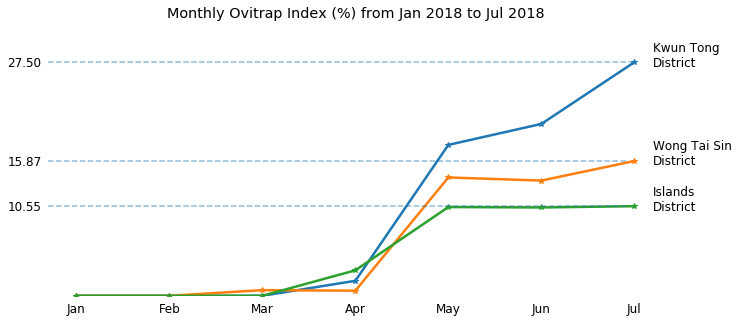

In [43]:
months_2018 = [i for i in range(1,8)]
months_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul']
highest_wtsd = max(wtsd_2018['monthly_aoi'])
highest_ktd = max(ktd_2018['monthly_aoi'])
highest_isd = max(isd_2018['monthly_aoi'])
fig, ax = plt.subplots(figsize=(11,5))
ax.plot(months_2018,ktd_2018['monthly_aoi'],marker='*',linewidth=2.5,label='Kwun Tong District')
ax.plot(months_2018,wtsd_2018['monthly_aoi'],marker='*',linewidth=2.5,label='Wong Tai Sin District')
ax.plot(months_2018,isd_2018['monthly_aoi'],marker='*',linewidth=2.5,label='Islands District')
plt.axhline(highest_ktd,xmax=6.7/7,alpha=0.5,linestyle='--')
plt.axhline(highest_wtsd,xmax=6.6/7,alpha=0.5,linestyle='--')
plt.axhline(highest_isd,xmax=6.6/7,alpha=0.5,linestyle='--')
ax.text(7.2,highest_wtsd-0.5,'Wong Tai Sin\nDistrict',size='large')
ax.text(7.2,highest_ktd-0.5,'Kwun Tong\nDistrict',size='large')
ax.text(7.2,highest_isd-0.5,'Islands\nDistrict',size='large')
plt.ylim(0,32)
plt.xticks(months_2018,months_label,size='large')
plt.yticks([highest_wtsd,highest_ktd,highest_isd],size='large')
plt.tick_params(bottom=False,left=False)
for spine in ax.spines:
    ax.spines[spine].set_visible(False)
plt.title("Monthly Ovitrap Index (%) from Jan 2018 to Jul 2018",size='x-large')
plt.savefig('KTD_VS_WTSD')
plt.show()

In [33]:
wts_2018_q = '''
    SELECT 
        l.eng_location location,
        aoi.AOI*100 aoi_percentage
    FROM area_ovitrap_index aoi
    INNER JOIN location l ON aoi.location_id = l.location_id
    INNER JOIN district d ON l.district_id = d.district_id
    WHERE d.eng_district = 'Wong Tai Sin' AND aoi.date LIKE '%2018'
'''
kt_2018_q = '''
    SELECT 
        l.eng_location location,
        aoi.AOI*100 aoi_percentage
    FROM area_ovitrap_index aoi
    INNER JOIN location l ON aoi.location_id = l.location_id
    INNER JOIN district d ON l.district_id = d.district_id
    WHERE d.eng_district = 'Kwun Tong' AND aoi.date LIKE '%2018'
'''

wts_2018 = run_query(wts_2018_q)
kt_2018 = run_query(kt_2018_q)


In [44]:
months_2018 = [i for i in range(1,8)]
months_label = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug']

wtsc = wts_2018[wts_2018.location == 'Wong Tai Sin Central']
dh = wts_2018[wts_2018.location == 'Diamond Hill']
ncw = wts_2018[wts_2018.location == 'Ngau Chi Wan']
wtsd = [wtsc,dh,ncw]
wtsd_label = ['Wong Tai Sin Central','Diamond Hill','Ngau Chi Wan']

ktc = kt_2018[kt_2018.location=='Kwun Tong Central']
lt = kt_2018[kt_2018.location=='Lam Tin']
kb = kt_2018[kt_2018.location=='Kowloon Bay']
yt = kt_2018[kt_2018.location=='Yau Tong']
ktd = [ktc,lt,kb,yt]
ktd_label = ['Kwun Tong Central','Lam Tin','Kowloon Bay','Yau Tong']

district = [wtsd,ktd]
district_label = [wtsd_label,ktd_label]

subtitles = ['Wong Tai Sin District','Kwun Tong District']

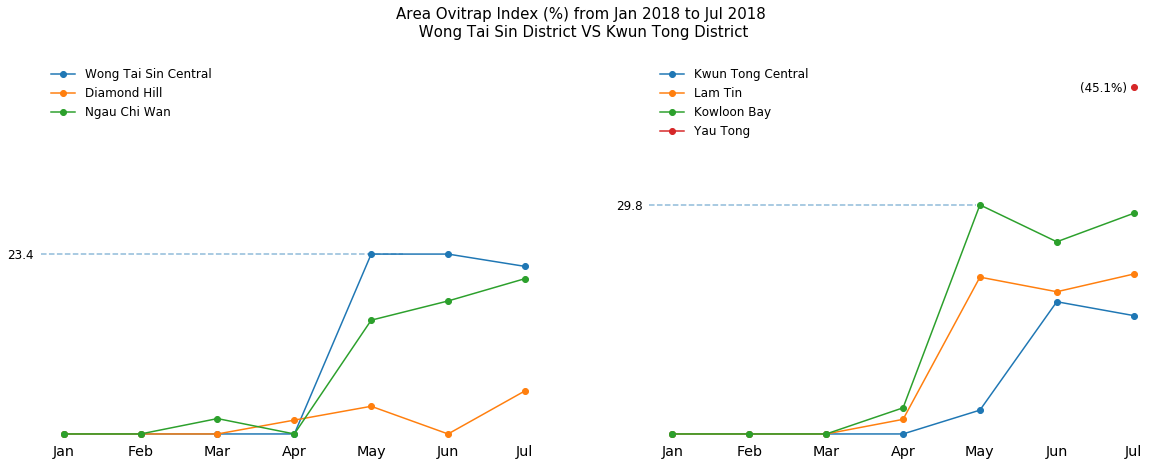

In [45]:
fig = plt.figure(figsize=(20,7))
fig.suptitle('Area Ovitrap Index (%) from Jan 2018 to Jul 2018\n Wong Tai Sin District VS Kwun Tong District',size='15')
for sp in range(2):
    ax = fig.add_subplot(1,2,sp+1)
    for each in range(4):
        try:
            plt.plot(months_2018,district[sp][each]['aoi_percentage'],marker='o',label=district_label[sp][each])
        except IndexError:
            pass
        except ValueError:
            plt.plot(7,yt['aoi_percentage'],marker='o',label='Yau Tong')
    plt.xticks(months_2018,months_label,size='x-large')
    if sp == 0:
        plt.yticks([max(wts_2018['aoi_percentage'])],size='large')
        plt.axhline(max(wts_2018['aoi_percentage']),xmax=5/7,alpha=0.5,linestyle='--')
    elif sp == 1:
        plt.yticks([max(kb['aoi_percentage'])],size='large')
        plt.axhline(max(kb['aoi_percentage']),xmax=4.5/7,alpha=0.5,linestyle='--')
    plt.legend(loc='upper left',frameon=False,fontsize='large')
    plt.ylim(-0.5,49)
    plt.tick_params(bottom=False,left=False)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    if sp == 1:
        ax.text(6.3,yt['aoi_percentage']-0.6,'(45.1%)',size='large')
plt.savefig('AOI_WTS_KT_2018')    
plt.show()